# Libraries used

In [1]:
import pandas as pd
import numpy as np
import datetime
import scipy.stats as stats
from scipy.stats import t
import math
import statsmodels.api as sm
from statsmodels.stats import proportion
import matplotlib.pyplot as plt

# Data Collection

Data set delivered by Masterschool:
3 files download from https://bit.io

In [2]:
df1 = pd.read_csv('users.csv') # user demographic information
df2 = pd.read_csv('groups.csv') # user A/B test group assignment
df3 = pd.read_csv('activity.csv') # user purchase activity, containing 1 row per day that a user made a purchase

print(df1.shape)
print(df2.shape)
print(df3.shape)

(48943, 3)
(48943, 4)
(2233, 4)


# Join
Merge all csv files together by id

In [3]:
# join data
globox = df1.merge(df2[['group', 'join_dt', 'device', 'uid']], how = 'inner',
                left_on = 'id', right_on = 'uid').drop(columns = ['uid', 'device']).merge(df3[['uid', 'dt', 'device', 'spent']],how = 'left',
                left_on = 'id', right_on = 'uid').drop(columns = ['uid'])
globox.head()

,id,country,gender,group,join_dt,dt,device,spent
0,1000000,CAN,M,B,2023-01-28,NaN,NaN,NaN
1,1000001,BRA,M,A,2023-01-27,NaN,NaN,NaN
2,1000002,FRA,M,A,2023-02-01,NaN,NaN,NaN
3,1000003,BRA,M,B,2023-01-25,NaN,NaN,NaN
4,1000004,DEU,F,A,2023-02-04,NaN,NaN,NaN


# EDA

In [4]:
# information about data
print(globox.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49082 entries, 0 to 49081
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       49082 non-null  int64  
 1   country  48435 non-null  object 
 2   gender   42200 non-null  object 
 3   group    49082 non-null  object 
 4   join_dt  49082 non-null  object 
 5   dt       2233 non-null   object 
 6   device   2223 non-null   object 
 7   spent    2233 non-null   float64
dtypes: float64(1), int64(1), object(6)
memory usage: 3.4+ MB
None


In [5]:
# Display all columns and rows
pd.set_option('display.max_columns', 8) 
pd.set_option('display.max_rows', 49082)

In [6]:
pd.crosstab(globox['group'], globox['group'])

group,A,B
group,,
A,24402,0
B,0,24680


In [7]:
pd.crosstab(globox['group'], globox['gender'])

gender,F,M,O
group,,,
A,10104,10069,809
B,10096,10258,864


In [8]:
country = pd.crosstab(globox['group'], globox['country'])
pd.set_option('display.max_columns',10)
country

country,AUS,BRA,CAN,DEU,ESP,FRA,GBR,MEX,TUR,USA
group,,,,,,,,,,
A,608,4818,770,1912,997,1539,1457,2820,1852,7330
B,560,4635,803,1958,1003,1558,1501,2934,1889,7491


In [9]:
sum_spent = globox.groupby('group')['spent'].sum()
print(round(sum_spent, 2))

group
A    82145.90
B    83415.33
Name: spent, dtype: float64


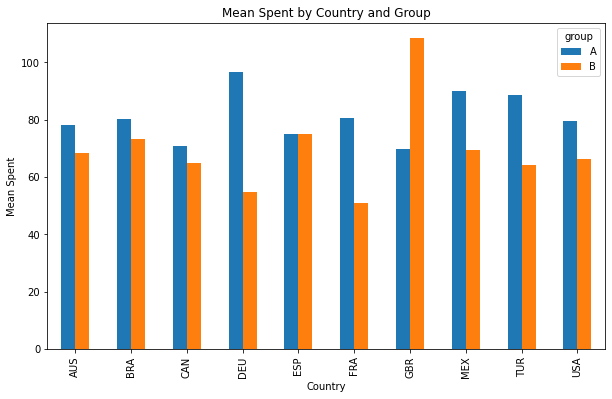

In [10]:
# Group the data by group and country, and calculate the mean of the spent column for each group
grouped_data = globox.groupby(['group','country'])['spent'].mean().reset_index()

# Pivot the data to create separate columns for each group
pivoted_data = grouped_data.pivot(index='country', columns='group', values='spent')

# Create a bar plot of the means for each group by country
pivoted_data.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Country')
plt.ylabel('Mean Spent')
plt.title('Mean Spent by Country and Group')
plt.show()

In [11]:
globox.groupby('group')['spent'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,1014.0,81.011739,95.935897,0.815058,38.685000,62.62,98.8175,1659.4
B,1219.0,68.429308,89.440967,0.340320,30.632592,51.16,81.8000,1546.3


# Data Cleansing

* replace null values in column 'spent' with zeros

In [12]:
# replace null values in column spent with zeros
globox['spent'] = globox['spent'].fillna(0)
globox.isnull().sum()

id             0
country      647
gender      6882
group          0
join_dt        0
dt         46849
device     46859
spent          0
dtype: int64

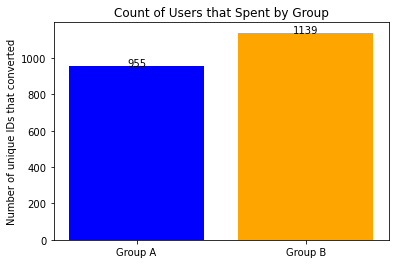

In [13]:
# add new column converted (users who spent = 1, users who do not = 0)
globox['converted'] = np.where(globox['spent'] > 0.0, 1, 0)

group_a_converted = len(globox[(globox['group'] == 'A') & (globox['converted'] > 0)]['id'].unique())
group_b_converted = len(globox[(globox['group'] == 'B') & (globox['converted'] > 0)]['id'].unique())

# Create a bar chart
fig, ax = plt.subplots()
ax.bar(['Group A', 'Group B'], [group_a_converted, group_b_converted], color=['blue', 'orange'])

# Add labels and title
ax.set_ylabel('Number of unique IDs that converted')
ax.set_title('Count of Users that Spent by Group')

# Add text labels to the top of each bar
ax.text(0, group_a_converted + 0.1, group_a_converted, ha='center', fontsize=10)
ax.text(1, group_b_converted + 0.1, group_b_converted, ha='center', fontsize=10)

# Show the plot
plt.show()



**"We have 139 Duplicate users that bought more than one in diffent time, we need to filter en future medicion"


In [14]:
#review if I have duplicate users
counter = globox['id'].value_counts()
(counter > 1).value_counts()

False    48804
True       139
Name: id, dtype: int64

# Experimentation

Context

The Globox team run an A/B test to increase revenue by bringing awareness to key products in the food and drink category through a banner at the top of the website,  as shown below. 

The company aims to further boost revenue by increasing awareness of this product category

<img src= "https://user-images.githubusercontent.com/109522662/234674055-71d68fb0-678d-4513-a0f8-10b32df8b88b.png" width="300" height="100">

The experiment was conducted on the mobile website, and the users were randomly assigned to either the control or test group. The metrics used to measure the success of the experiment were the Conversion Rate of action purchases. Data was collected for 12 days, and a total of 48943 unique users visited the website, of which 24343 were in the control group (A) and 24600 were in the experimental group (B).

Alpha = 0.05


Number of unique users in esperiment: 48943
Data collected for 12 days
Group to compare: ['B', 'A']
Number of unique users in both group
A    24343
B    24600
Name: id, dtype: int64


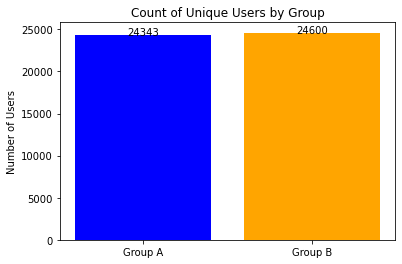

In [15]:
# how long did it run
start_time = datetime.datetime.strptime(globox['join_dt'].min(), '%Y-%m-%d')
end_time = datetime.datetime.strptime(globox['join_dt'].max(), '%Y-%m-%d')
data_duration = (end_time - start_time).days

print(f"Number of unique users in esperiment: {globox['id'].nunique()}")
print(f"Data collected for {data_duration} days")
print(f"Group to compare: {globox['group'].unique().tolist()}")
print(f"Number of unique users in both {globox.groupby(['group'])['id'].nunique()}")

# Gragh 
users_A= len(globox[globox['group'] == 'A']['id'].unique())
users_B = len(globox[globox['group'] == 'B']['id'].unique())

fig, ax = plt.subplots()
ax.bar(['Group A', 'Group B'], [users_A, users_B], color=['blue', 'orange'])

# Add labels and title
ax.set_ylabel('Number of Users')
ax.set_title('Count of Unique Users by Group')

# Add text labels to the top of each bar
ax.text(0, users_A + 0.1, users_A, ha='center', fontsize=10)
ax.text(1, users_B + 0.1, users_B, ha='center', fontsize=10)

# Show the plot
plt.show()


#### What is the average amount spent per user for the control and treatment groups?

In [16]:

#What is the average amount spent per user for the control and treatment groups?
avg_amount = globox.groupby('group')['spent'].mean()

print(f"Average amount spent per user for the control (A): ${avg_amount['A'].round(decimals = 4)}")
print(f"Average amount spent per user for the treatment (B): ${avg_amount['B'].round(decimals = 4)}")


Average amount spent per user for the control (A): $3.3664
Average amount spent per user for the treatment (B): $3.3799


#### What is the 95% confidence interval for the average amount spent per user in the control (use t distribution) 

* One-sample 
* t-interval for means

In [17]:

# filters group control A
filt_A = globox[globox['group'] == 'A']['spent']
# users unique group A
n_A = len(globox.loc[globox['group']== 'A']['id'].unique())
# Specify Parameters
sample_mean_A = filt_A.mean()
sample_std_A = filt_A.std(ddof=1)
sample_size_A = n_A
conf_level_A = 0.95

# Calculate alpha, degrees of freedom (df), the critical t-value, and the margin of error
alpha = (1-conf_level_A)
df = n_A -1
standard_error = sample_std_A/math.sqrt(sample_size_A)
critical_t = stats.t.ppf(1-alpha/2, df)
margin_of_error = critical_t * standard_error

# Calculate the lower and upper bound of the confidence interval
lower_bound = sample_mean_A - margin_of_error
upper_bound = sample_mean_A + margin_of_error

# Print the results
print("Critical t-value: {:.3f}".format(critical_t))
print("Margin of Error: {:.3f}".format(margin_of_error))
print("Confidence Interval: [{:.3f},{:.3f}]".format(lower_bound,upper_bound))
print("The {:.1%} confidence interval for the average amount spent per user in the control:".format(conf_level_A))
print("between {:.3f} and {:.3f}".format(lower_bound,upper_bound))


Critical t-value: 1.960
Margin of Error: 0.319
Confidence Interval: [3.048,3.685]
The 95.0% confidence interval for the average amount spent per user in the control:
between 3.048 and 3.685


#### What is the 95% confidence interval for the average amount spent per user in the treatment? (use t distribution) 

* One-sample 
* t-interval for means

There is a 95% chance that the confidence interval of [3.070,3.690] contains the true population mean amount spent per user in the treatment



In [18]:

# filters group control B
filt_B = globox[globox['group'] == 'B']['spent']
# users unique group B
n_B = len(globox.loc[globox['group']== 'B']['id'].unique())
# Specify Parameters
sample_mean_B = filt_B.mean()
sample_std_B = filt_B.std(ddof=1)
sample_size_B = n_B
conf_level_B = 0.95

# Calculate alpha, degrees of freedom (df), the critical t-value, and the margin of error
alpha = (1-conf_level_B)
df = n_B -1
standard_error = sample_std_B/math.sqrt(sample_size_B)
critical_t = stats.t.ppf(1-alpha/2, df)
margin_of_error = critical_t * standard_error

# Calculate the lower and upper bound of the confidence interval
lower_bound = sample_mean_B - margin_of_error
upper_bound = sample_mean_B + margin_of_error

# Print the results
print("Critical t-value: {:.3f}".format(critical_t))
print("Margin of Error: {:.3f}".format(margin_of_error))
print("Confidence Interval: [{:.3f},{:.3f}]".format(lower_bound,upper_bound))
print("The {:.1%} confidence interval for the average amount spent per user in the treatment:".format(conf_level_A))
print("between {:.3f} and {:.3f}".format(lower_bound,upper_bound))


Critical t-value: 1.960
Margin of Error: 0.310
Confidence Interval: [3.070,3.690]
The 95.0% confidence interval for the average amount spent per user in the treatment:
between 3.070 and 3.690


#### Conduct a hypothesis test to see whether there is a difference in the average amount spent per user between the two groups. What are the resulting p-value and conclusion?

* Use the t distribution and a 5% significance level. 
* Assume unequal variance.

**HO: there is NOT a difference in the average amount spent per user between the two groups uA = uB
**H1: there is a difference in the average amount spent per user between the two groups uA != uB

In [19]:
# Two-sample t-test
# Get Sample
sample_A = globox[globox['group']=='A']['spent']
sample_B = globox[globox['group']=='B']['spent']

#Now we'll compare two sets of samples. Use the t distribution and a 5% significance level. Assume equal variance
t_result = stats.ttest_ind(sample_A, sample_B)

alpha = 0.05
if (t_result[1] < alpha):
     print(f"Reject the null hypothesis. The data favors the alternative hypothesis \np-value: {t_result[1].round(decimals = 2)}")
else:
    print(f"Fail to reject the null hypothesis, results are not significant \np-value: {t_result[1].round(decimals = 2)}")


Fail to reject the null hypothesis, results are not significant 
p-value: 0.95


#### What is the 95% confidence interval for the difference in the average amount spent per user between the treatment and the control (treatment-control)?

* Use the t distribution 
* Assume unequal variance.

In [20]:

# Calculate the standard error of the difference
std_error_diff = ((sample_std_A ** 2 / n_A) + (sample_std_B ** 2 / n_B)) ** 0.5

# Calculate the t-score based on the 95% confidence level and degrees of freedom
t_score = stats.t.ppf(0.975, df=n_A + n_B -2)

# Calculate the margin of error
margin_of_error_diff = t_score * std_error_diff

# Calculate the confidence interval
CI_diff_low = (avg_amount['B'] - avg_amount['A'] - margin_of_error_diff)
CI_diff_high = (avg_amount['B'] - avg_amount['A'] + margin_of_error_diff)

# Print the confidence interval
print("The 95% CI for the diff. in the average amount spent per user between A and B: [{:.3f},{:.3f}]".format(CI_diff_low, CI_diff_high))


The 95% CI for the diff. in the average amount spent per user between A and B: [-0.431,0.458]


## Conduct a hypothesis test to see whether there is a difference in the average amount spent per user between the two groups

### Conclusion

* There is no significant difference in the average amount spent per user between the control group (A) and treatment group (B). This is supported by the fact that the p-value for the hypothesis test is 0.95, which is greater than the typical alpha level of 0.05. Additionally, the 95% confidence intervals for the average amount spent per user in both groups overlap, indicating that there is a high probability that the true means are similar. Finally, the 95% CI for the difference in means between A and B is [-0.431, 0.458], which includes 0 and further supports the conclusion that there is no significant difference between the two groups. Overall, these results suggest that the new treatment did not have a significant impact on the average amount spent per user compared to the control group.

#### What is the user conversion rate for the control and treatment groups?

User conversion rate for the control group: 3.92%
User conversion rate for the treatment group: 4.63%
Diff = 0.71%


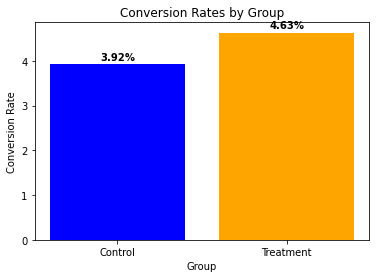

In [21]:

#Count the number of unique users in each group
users_A= set(globox[globox['group'] == 'A']['id'].unique())
users_B = set(globox[globox['group'] == 'B']['id'].unique())

#Count the number of users who spent in each group
spent_A = set(globox[(globox['group'] == 'A') & (globox['spent'] > 0)]['id'].unique())
spent_B = set(globox[(globox['group'] == 'B') & (globox['spent'] > 0)]['id'].unique())

#Calculate the user conversion rate for each group
control_conversion_rate = round(len(spent_A)*100 / len(users_A), 2)
treatment_conversion_rate = round(len(spent_B)*100 / len(users_B),2)
diff = round(treatment_conversion_rate - control_conversion_rate, 2)

#Print the user conversion rate for each group
print(f"User conversion rate for the control group: {control_conversion_rate}%")
print(f"User conversion rate for the treatment group: {treatment_conversion_rate}%")
print(f"Diff = {diff}%")

fig, ax = plt.subplots()
ax.bar(['Control', 'Treatment'], [control_conversion_rate, treatment_conversion_rate], color=['blue', 'orange'])
for i, v in enumerate([control_conversion_rate,treatment_conversion_rate]):
    ax.text(i, v + 0.1, str(v)+'%', ha='center', fontweight='bold')
# Set the title and labels
ax.set_title('Conversion Rates by Group')
ax.set_xlabel('Group')
ax.set_ylabel('Conversion Rate')
plt.show()


#### What is the 95% confidence interval for the conversion rate of users in the control?

* Use the normal distribution.
* one-sample 
* z-interval for proportions

In [22]:

num_success = len((globox[(globox['group'] == 'A') & (globox['spent'] > 0)]['id'].unique()))# number of successful purchase
num_obser = len(globox.loc[globox['group']== 'A']['id'].unique()) # number of observation (customer exposed to the old landing page)
CIA = proportion.proportion_confint(num_success, num_obser, alpha=0.05, method='normal')

print(f"95% CI conversion rate for the control group: {np.round(CIA, 4)}")


95% CI conversion rate for the control group: [0.0368 0.0417]


#### What is the 95% confidence interval for the conversion rate of users in the treatment?

* Use the normal distribution.
* one-sample 
* z-interval for proportions

In [23]:

num_success = len((globox[(globox['group'] == 'B') & (globox['spent'] > 0)]['id'].unique()))# number of successful purchase
num_obser = len(globox.loc[globox['group']== 'B']['id'].unique()) # number of observation (customer exposed to the old landing page)
CIB = proportion.proportion_confint(num_success, num_obser, alpha=0.05, method='normal')

print(f"95% CI conversion rate for the control treatment: {np.round(CIB, 4)}")


95% CI conversion rate for the control treatment: [0.0437 0.0489]


#### Conduct a hypothesis test to see whether there is a difference in the conversion rate between the two groups. What are the resulting p-value and conclusion?
pooled proportion for the standard error

* Use the normal distribution and a 5% significance level. 
* two-sample 
* two-sided z-interval for a difference in proportions. 
* Assuming equal proportions

**HO: The difference in the CONVERTION RATE between the two groups uA - uB = 0
**H1: The difference in the CONVERTION RATE between the two groups uA - uB != 0

In [24]:
## Parameters
success_a = len((globox[(globox['group'] == 'A') & (globox['spent'] > 0)]['id'].unique()))# number of successful purchase
size_a = len(globox.loc[globox['group']== 'A']['id'].unique()) #Size
success_b = len((globox[(globox['group'] == 'B') & (globox['spent'] > 0)]['id'].unique()))# number of successful purchase
size_b = len(globox.loc[globox['group']== 'B']['id'].unique()) # Size
significance = 0.05

# check our sample against Ho for Ha != Ho
successes = np.array([success_a, success_b])
samples = np.array([size_a, size_b])

stat, p_value = proportion.proportions_ztest(count=successes, nobs=samples,  alternative='two-sided')

# report
print('z_stat: %0.3f, p_value: %0.5f' % (stat, p_value))

if p_value > 0.05:
   print ("Fail to reject the null hypothesis")
else:
   print ("Reject the null hypothesis that there is no difference in the user conversion rate between the control and treatment.")


z_stat: -3.864, p_value: 0.00011
Reject the null hypothesis that there is no difference in the user conversion rate between the control and treatment.


#### What is the 95% confidence interval for the difference in the conversion rate between the treatment and control (treatment-control)?


* Use the normal distribution and unpooled proportions for the standard error.
* two-sample 
* z-interval for a difference in proportions. Without assuming the proportions are the same
* we use the unpooled standard error. 
* Subtracting the control proportion from the treatment proportion (treatment - control) and not the other way around.

In [25]:
# size
size_a = len(globox.loc[globox['group']== 'A']['id'].unique())
size_b = len(globox.loc[globox['group']== 'B']['id'].unique())

# Parameters
control_conversion_rate = len(spent_A) / size_a
treatment_conversion_rate = len(spent_B) / size_b

# Calculate the difference in conversion rates
dif_conversion_rate = treatment_conversion_rate - control_conversion_rate

# Calculate the standard error of the difference in conversion rates
se_dif = np.sqrt((treatment_conversion_rate * (1 - treatment_conversion_rate) / size_b) + (control_conversion_rate * (1 - control_conversion_rate) / size_a))

# Calculate the 95% confidence interval using the normal distribution and unpooled proportions
CI_dif = (dif_conversion_rate - stats.norm.ppf(0.975) * se_dif, dif_conversion_rate + stats.norm.ppf(0.975) * se_dif)


print(f"95% CI for the difference in the conversion rate between A and B: {np.round(CI_dif, 4)}")


95% CI for the difference in the conversion rate between A and B: [0.0035 0.0107]


## Conduct a hypothesis test to see whether there is a difference in the conversion rate between the two groups

### Conclusion

* Based on the results of the experiment, we can conclude that the new banner had a statistically significant effect on the conversion rate. The data showed that the treatment group had a higher conversion rate compared to the control group, with a difference of 0.71%. This difference was found to be statistically significant as evidenced by the p-value of 0.00011, which was less than the significance level of 0.05.

* Furthermore, the 95% confidence interval for the difference in conversion rate between the control and treatment groups did not include zero, which provides additional evidence for the statistical significance of the result. The interval was [0.0035, 0.0107], which suggests that we can be 95% confident that the true difference in conversion rate between the two groups lies within this range. Therefore, we can conclude that the new banner had a statistically significant effect on the conversion rate.


In [26]:
from statsmodels.stats.power import TTestIndPower

# Define parameters
alpha = 0.05
n1 = 24343 # sample A
n2 = 24600 # sample B
p1 = 0.0392 # conv. rate A
p2 = 0.0463 # conv. rate B

# Compute effect size (Cohen's d)
s1 = p1*(1-p1) # standard deviation of group 1
s2 = p2*(1-p2) # standard deviation of group 2
s = ((n1-1)*s1 + (n2-1)*s2) / (n1+n2-2) # pooled standard deviation
Cohen_effect_size = abs(p2 - p1) / (s**0.5) # Cohen's d, which is a measure of the standardized effect size


print(f"Estimation effect size: {round(Cohen_effect_size, 4)}")


Estimation effect size: 0.0351


In [27]:
# Calculation Sample size to achieve power = 0.2, power = 0.5, power = 0.8

# Set parameters
alpha = 0.05
effect_sizes = [0.0351]
power_values = [0.2, 0.5, 0.8]
ratios = [1]
nobs = []

# Loop through effect sizes, power values, and ratios
for es in effect_sizes:
    for pow in power_values:
        for ratio in ratios:
            # Create power analysis object
            power_analysis = TTestIndPower()
            
            # Calculate required sample size
            nobs.append(power_analysis.solve_power(effect_size=es, power=pow, alpha=alpha, ratio=ratio, alternative='two-sided'))

# Print results
for i in range(len(nobs)):
    print(f"For effect size = {effect_sizes[0]}, power = {power_values[i]}, sample size = {round(nobs[i])}")

For effect size = 0.0351, power = 0.2, sample size = 2018
For effect size = 0.0351, power = 0.5, sample size = 6236
For effect size = 0.0351, power = 0.8, sample size = 12743


# Recommendation

* I recommend that we do not launch it. Statistics showed a significant increase in Conversion Rate between the control and treatment groups, it is likely that the change had a positive impact on overall user engagement and behavior. However, the experiment only focused on highlighting key products in the food and drink category and it is uncertain whether this specific change contributed to the observed increase in conversion rate.

* To better understand the impact of the new banner, it may be useful to conduct further experiments or gather more data on user behavior, such as surveys or analyzing user feedback. Additionally, analyzing the types of products that were purchased by users in the experimental group could also help determine whether the new banner had a specific impact on the food and drink category or on overall purchasing behavior.
